## Prepare images for training

Resize images to 64 x 64 x 1. For simplicity's sake, only use single channel from RGB images.

In [1]:
from matplotlib import image
from os import listdir
from PIL import Image
import numpy as np
from numpy import expand_dims


def load_samples():
    loaded_img = []

    for file in listdir('/content/sample_data/pokemon_data/'):
        img = Image.open('/content/sample_data/pokemon_data/' + file)
        red, green, blue = img.split()
        img_resized = red.resize((64, 64))
        im2arr = np.array(img_resized)
        loaded_img.append(im2arr)

    X = np.asarray(loaded_img)
    X = expand_dims(X, axis=-1)
    X = X.astype('float32')
    X = X / 255.0
    return X

## Produce discriminator architecture

Use Leaky ReLU activation function after convolutions to reduce vanishing gradient problem to ensure better training for kernels. Additionally use Leaky ReLU  to add non-linearity to improve variance in learned kernels and allow model to adapt to various features.

Apply dropout layers as well to possibly remove some outputs and reduce overfitting.

Discriminator compresses images down into feature space. It is trained on real and fake images; therefore model is a convolutional neural network for binary-classification. 

In [2]:
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

def discriminator(in_shape=(64, 64, 1)):
    model = Sequential()
    model.add(Conv2D(64, (3, 3), strides=(4, 4), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model = discriminator()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Load in all pokemon image samples

In [3]:
trainX = load_samples()
trainX.shape

(819, 64, 64, 1)

## Produce real-image dataset for training discriminator

Select random images from existing dataset and assign real class label

In [4]:
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint

def generate_real_samples(dataset, n):
    ind = randint(0, dataset.shape[0], n)
    X = dataset[ind]
    y = ones((n, 1))
    return X, y

## Produce fake-image dataset for training discriminator

Create pixel-space for however many image samples are selected. Then transform the pixel space into n random images and provide a class label.

In [5]:
def generate_fake_samples(n):
    X = rand(64 * 64 * n)
    X = X.reshape((n, 64, 64, 1))
    y = zeros((n, 1))
    return X, y

## Train discriminator

Adjust kernel weights per each batch then check prediction accuracy. Train and test splits handled in background by function, train_on_batch().

Keras by default ignores first dimension of input, therefore even though fake and real samples have shape (n, 64, 64, 1), Keras will read it in as (64, 64, 1) and work correctly.

Additionally train_on_batch() is a specialised training algorithm as opposed to fit(). Training in batches reduces memory overhead and reduces processing time. 

Notice fast convergence of algorithm. Due to strongly randomized fake images it works quickly, however later when discriminator competes with generator, training time will increase.

In [6]:
def train_discriminator(model, dataset, n_iter=100, n_batch=128):
    half_batch = int(n_batch/2)
    
    for i in range(n_iter):
        X_real, y_real = generate_real_samples(dataset, half_batch)
        _, real_acc = model.train_on_batch(X_real, y_real)
        X_fake, y_fake = generate_fake_samples(half_batch)
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

model = discriminator()
train_discriminator(model, trainX)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


>1 real=56% fake=27%
>2 real=81% fake=9%
>3 real=89% fake=12%
>4 real=88% fake=5%
>5 real=94% fake=3%
>6 real=94% fake=6%
>7 real=95% fake=6%
>8 real=95% fake=5%
>9 real=95% fake=5%
>10 real=97% fake=2%
>11 real=98% fake=5%
>12 real=100% fake=2%
>13 real=98% fake=0%
>14 real=100% fake=2%
>15 real=100% fake=2%
>16 real=100% fake=0%
>17 real=100% fake=0%
>18 real=100% fake=0%
>19 real=100% fake=0%
>20 real=100% fake=0%
>21 real=100% fake=0%
>22 real=100% fake=2%
>23 real=100% fake=2%
>24 real=100% fake=2%
>25 real=100% fake=2%
>26 real=100% fake=2%
>27 real=100% fake=0%
>28 real=100% fake=2%
>29 real=100% fake=5%
>30 real=100% fake=2%
>31 real=100% fake=5%
>32 real=100% fake=6%
>33 real=100% fake=3%
>34 real=100% fake=5%
>35 real=100% fake=2%
>36 real=100% fake=11%
>37 real=100% fake=11%
>38 real=100% fake=8%
>39 real=100% fake=19%
>40 real=100% fake=11%
>41 real=100% fake=19%
>42 real=100% fake=23%
>43 real=100% fake=41%
>44 real=100% fake=27%
>45 real=100% fake=53%
>46 real=100% fake=5

## Create generator
Generator learns to map 100-dim input vector to images by using multiple upsampling operations (transpose-convolutions) and then outputting a regularized image. 

First dense layer creates pixel-space for 128, 16 x 16 images, and maps the 100-dim vector to that pixel-space.

Applies multiple kernels to learn mapping more accurately for added variance.

In [7]:
from keras.layers import Reshape
from keras.layers import Conv2DTranspose

def generator(latent_dim):
    model = Sequential()
    n_nodes = 128 * 16 * 16
    
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((16, 16, 128)))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (16, 16), activation='sigmoid', padding='same'))
    return model
    
latent_dim = 100
model = generator(latent_dim)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32768)             3309568   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 128)       262272    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 64, 64, 128)      

Generate latent space for generator to learn to associate vectors to images with by creating random points and reshaping into a 100-dim vector. Then let untrained generator produce images from latent space.

In [8]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [9]:
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = g_model.predict(x_input)
    y = zeros((n_samples, 1))
    return X, y

## Display generated images from (untrained) generator

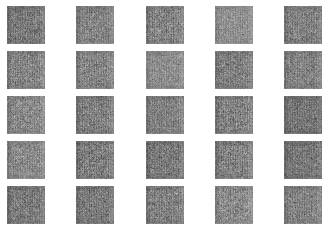

In [10]:
from matplotlib import pyplot
from numpy.random import randn

n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
for i in range(n_samples):
    pyplot.subplot(5, 5, 1 + i)
    pyplot.axis('off')
    pyplot.imshow(X[i, :, :, 0], cmap='gray_r')

pyplot.show()

## Formulate GAN
GAN is composed of generator and discriminator. The generator produces samples that are always classifed as real and fed into the discriminator. The discriminator then classifies the samples are real or fake, and its weights are not adjusted as it is trained beforehand.

When a fake sample is produced by the generator, but classified as real, then the discriminator will classify it as fake (as intended). This creates a large training error and drives the entire GAN to adjust its weights thereby making the generator produce better fake samples. 

Therefore model performance and training accuracy is contingent upon the discriminator correctly classifying samples.

Entire GAN takes a point in latent space, generates an image from it and classifies it using the discriminator. Therefore the intuitive architecture is a generator network that feeds into a discriminator network

In [11]:
def gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = Adam(lr=0.0002, beta_1 = 0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model
latent_dim = 100
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = gan(g_model, d_model)
gan_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_4 (Sequential)    (None, 64, 64, 1)         3866881   
_________________________________________________________________
sequential_3 (Sequential)    (None, 1)                 41665     
Total params: 3,908,546
Trainable params: 3,866,881
Non-trainable params: 41,665
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Saving the Model and Images
Save GAN weights every few training iterations and additionally plot produced images

In [12]:
def save_plot(examples, epoch, n=10):
    for i in range(n * n):
        pyplot.subplot(n, n, 1 + i)
        pyplot.axis('off')
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

## Evaluating the Model
Cannot objectively evaluate error for generator as it directly feeds into discriminator and overall GAN's performance is evaluated. 

However to isolate the generator's performance, can evaluate classification accuracy of the discriminator, generate images for review and save the generator model for image production later on


In [15]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = generate_real_samples(dataset, n_samples)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    
    save_plot(x_fake, epoch)
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

## Training the GAN
Formulate n latent space vectors and pass in to the network. Each vector corresponds to a generated image that is assumed to be real (1), therefore the output per each sample is 1. 

Train the GAN by the above mentioned data flow until the discriminator makes the generator produce better fake samples.

Must train the discriminator first to identify real and fake samples. Then afterwards freeze the discriminator's weights and layers and use it in the composite GAN model to train the generator until it produces better fakes. Therefore both training functions must be utilized for all parts to work together.

Generate real and fake samples, then stack all sample tuples (of images and classes) along the rows by applying vstack. Train the discriminator on the mixed sample set. Then generate multiple samples using the generator and train those using the discriminator. Repeat the process for multiple batches 

In [16]:
from numpy import vstack
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
    bat_per_repo = int(dataset.shape[0]/n_batch)
    half_batch = int(n_batch / 2)
    
    for i in range(n_epochs):
        
        if(i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
        
        for j in range(bat_per_repo):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            d_loss, _ = d_model.train_on_batch(X, y)
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = ones((n_batch, 1))
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_repo, d_loss, g_loss))
            
train(g_model, d_model, gan_model, trainX, latent_dim)

>1, 1/3, d=0.656, g=0.733
>1, 2/3, d=0.666, g=0.700
>1, 3/3, d=0.668, g=0.670
>2, 1/3, d=0.667, g=0.653
>2, 2/3, d=0.668, g=0.628
>2, 3/3, d=0.684, g=0.642
>3, 1/3, d=0.674, g=0.656
>3, 2/3, d=0.684, g=0.662
>3, 3/3, d=0.682, g=0.667
>4, 1/3, d=0.713, g=0.644
>4, 2/3, d=0.717, g=0.627
>4, 3/3, d=0.717, g=0.608
>5, 1/3, d=0.721, g=0.583
>5, 2/3, d=0.736, g=0.572
>5, 3/3, d=0.752, g=0.563
>6, 1/3, d=0.748, g=0.553
>6, 2/3, d=0.749, g=0.559
>6, 3/3, d=0.744, g=0.564
>7, 1/3, d=0.739, g=0.565
>7, 2/3, d=0.730, g=0.575
>7, 3/3, d=0.727, g=0.585
>8, 1/3, d=0.722, g=0.596
>8, 2/3, d=0.712, g=0.619
>8, 3/3, d=0.716, g=0.637
>9, 1/3, d=0.699, g=0.644
>9, 2/3, d=0.692, g=0.657
>9, 3/3, d=0.687, g=0.686
>Accuracy real: 100%, fake: 25%
>10, 1/3, d=0.689, g=0.704
>10, 2/3, d=0.681, g=0.718
>10, 3/3, d=0.684, g=0.726
>11, 1/3, d=0.692, g=0.736
>11, 2/3, d=0.693, g=0.758
>11, 3/3, d=0.686, g=0.775
>12, 1/3, d=0.680, g=0.782
>12, 2/3, d=0.692, g=0.785
>12, 3/3, d=0.684, g=0.791
>13, 1/3, d=0.682, g=0.

## Loading and Using the Model

IndexError: ignored

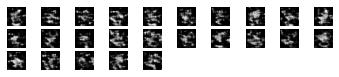

In [19]:
from keras.models import load_model

model = load_model('/content/generator_model_100.h5', compile=False)
latent_points = generate_latent_points(100, 25)
X = model.predict(latent_points)
save_plot(X, 5)